## Calculating red edge absorption line height 
### via methods of Roesler and Barnard et al 2013

# WHAT IS MISSING? A conversion from absorbance to absorption

In [ ]:
# wavelengths = [412.0, 440.0, 488.0, 510.0, 532.0, 555.0, 650.0, 676.0, 715.0]
# wavelengths = [int(i) for i in wavelengths]

In [1]:
from fopt_toolkit import fopt_toolkit as fp
import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
vic_cal_filepath = fp.make_dir('Data/5_final_vical')
lineheight_filepath = fp.make_dir('Data/8_abs_heights')

In [3]:
file_list = sorted(glob.glob(vic_cal_filepath+'/*.csv'))

### Test example
*** Using Scoter (??) lake because it actually has a fairly discernable red edge ***

Pull the filename for Scoter Lake absorbance

In [4]:
for i in file_list:
    if 'sco_a' in i:
        test = i

Get csv, set wavelengths as the index

In [8]:
test_df = pd.read_csv(test, skiprows=0, delimiter= '\t')

In [9]:
test_df['wl'] = test_df['wl'].astype(int)
test_df = test_df.set_index('wl')

In [10]:
test_df

,mean,std
wl,,
412,2.182533,0.136154
440,1.865062,0.116635
488,1.292098,0.101955
510,1.112447,0.098113
532,0.934224,0.097847
555,0.812657,0.095685
650,0.603464,0.090841
676,0.618950,0.089877
715,0.454805,0.090603


Set mean absorbances of target wavelengths as call-able variables

In [11]:
val_650 = test_df.loc[650,'mean']
val_676 = test_df.loc[676,'mean']
val_715 = test_df.loc[715,'mean']

Calculate:
1. slope of the line between absorption at 650nm and absorption at 715nm
2. intercept of aforementioned line (this is not necessary for getting absorbance height; this is just for graphing the example)
3. baseline value - the y value on the line between 650 and 715 corresponding to the x value 676

In [12]:
slope = (val_715-val_650)/(715-650)
intercept = val_715 - slope*715
baseline = slope*(676-650)+val_650

Line graphing function that I stole from somebody on stackexchange

In [13]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
## From https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib

Graphing it all for fun - does it all seem to match up? Yes, yes it does.

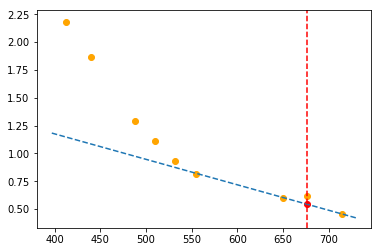

In [14]:
plt.scatter(x=test_df.index, y='mean', data=test_df, color='orange')
plt.plot(676, baseline, 'ro',color="red")
abline(slope, intercept)
plt.axvline(x=676, linestyle='--',color='red')
plt.show()

Final step: get absorption height at 676nm

In [15]:
absorption_height = val_676-baseline

### For all vicarious calibration files

Get absorption heights for all vicariously calibrated absorbance files

In [16]:
lakes = []
absorption_heights = []
for file_path in file_list:
    file_name_cols = file_path.split('/')[-1].split('.')[0].split('_')
    sample_type = file_name_cols[2]
    if sample_type == 'a':
        lake_name = file_name_cols[1]
        lakes.append(lake_name)
        df = pd.read_csv(file_path, skiprows=0, delimiter= '\t')
        df['wl'] = df['wl'].astype(int)
        df = df.set_index('wl')
        val_650 = df.loc[650,'mean']
        val_676 = df.loc[676,'mean']
        val_715 = df.loc[715,'mean']
        slope = (val_715-val_650)/(715-650)
        baseline = slope*(676-650)+val_650
        absorption_height = val_676-baseline
        absorption_heights.append(absorption_height)

Put into dataframe; make lake names the index

In [17]:
abs_heights = pd.DataFrame(
                    {'Lake':lakes,
                     'Abs_height':absorption_heights})
abs_heights = abs_heights.set_index('Lake').rename_axis(None, axis=0)

Yaaay

In [18]:
abs_heights

,Abs_height
9mi,0.071748
bai,0.156638
boo,0.038902
cbr,0.030764
gre,0.060575
sco,0.074950
y17,0.092499
y20,0.022987


Save to csv

In [19]:
abs_heights.to_csv(lineheight_filepath+'/abs_heights.csv', sep='\t',index=True)